# 周期分析

计算最有效的周期指标，捕捉中短期价格反转。

菲舍尔转换，带通滤波器，超级震荡指标。



In [1]:
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("bmh")

## 读取数据

In [2]:
def read_binance_annual_ohlcv(year: int) -> pd.DataFrame:
    filepath = os.path.join("../data", f"binance_daily_ohlcv_{year}.csv")
    return pd.read_csv(filepath, index_col="timestamp", parse_dates=True)


years = [2022, 2023, 2024]
ohlcv = pd.concat((read_binance_annual_ohlcv(year) for year in years))

In [3]:
ohlcv_btc = ohlcv.query("symbol == 'BTC/USDT'").copy()
ohlcv_btc

,open,high,low,close,volume,symbol
timestamp,,,,,,
2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.46325,BTC/USDT
2022-01-02,47722.66,47990.00,46654.00,47286.18,18340.46040,BTC/USDT
2022-01-03,47286.18,47570.00,45696.00,46446.10,27662.07710,BTC/USDT
2022-01-04,46446.10,47557.54,45500.00,45832.01,35491.41360,BTC/USDT
2022-01-05,45832.01,47070.00,42500.00,43451.13,51784.11857,BTC/USDT
...,...,...,...,...,...,...
2024-04-05,68487.80,68756.67,65952.56,67820.62,37915.23073,BTC/USDT
2024-04-06,67820.63,69692.00,67447.83,68896.00,20134.28919,BTC/USDT
2024-04-07,68896.00,70326.29,68824.00,69360.39,21534.74433,BTC/USDT


In [4]:
def fisher_transform(series: pd.Series, period: int = 10) -> pd.Series:
    highest = series.rolling(period, min_periods=1).max()
    lowest = series.rolling(period, min_periods=1).min()
    values = np.zeros(len(series))
    fishers = np.zeros(len(series))

    for i in range(1, len(series)):
        values[i] = (
            0.66
            * (
                (series.iloc[i] - lowest.iloc[i]) / (highest.iloc[i] - lowest.iloc[i])
                - 0.5
            )
            + 0.67 * values[i - 1]
        )
        values[i] = max(min(values[i], 0.999), -0.999)
        fishers[i] = (
            0.5 * np.log((1 + values[i]) / (1 - values[i])) + 0.5 * fishers[i - 1]
        )

    return pd.Series(fishers, index=series.index)


def bandpass(series: pd.Series, period: int = 10, bandwidth: float = 0.5) -> pd.Series:
    const = bandwidth * 2 * np.pi / period
    beta = np.cos(2 * np.pi / period)
    gamma = 1 / np.cos(const)
    alpha1 = gamma - np.sqrt(gamma**2 - 1)
    alpha2 = (np.cos(0.25 * const) + np.sin(0.25 * const) - 1) / np.cos(0.25 * const)
    alpha3 = (np.cos(1.5 * const) + np.sin(1.5 * const) - 1) / np.cos(1.5 * const)

    hp = np.zeros(len(series))
    bp = np.zeros(len(series))
    peaks = np.zeros(len(series))
    signals = np.zeros(len(series))

    for i in range(2, len(series)):
        hp[i] = (1 + alpha2 / 2) * (series.iloc[i] - series.iloc[i - 1]) + (
            1 - alpha2
        ) * hp[i - 1]
        bp[i] = (
            0.5 * (1 - alpha1) * (hp[i] - hp[i - 2])
            + beta * (1 + alpha1) * bp[i - 1]
            - alpha1 * bp[i - 2]
        )
        peaks[i] = 0.991 * peaks[i - 1]
        if abs(bp[i]) > peaks[i]:
            peaks[i] = abs(bp[i])
        if peaks[i] != 0:
            signals[i] = bp[i] / peaks[i]

    return pd.Series(signals, index=series.index)


def _center_gravity(series: pd.Series) -> float:
    nm = 0
    dm = 0
    reversed_series = series[::-1]
    for i, value in enumerate(reversed_series):
        nm += (i + 1) * value
        dm += value
    try:
        return -nm / dm + (len(series) + 1) / 2
    except ZeroDivisionError:
        return 0


def stoch_center_gravity_osc(series: pd.Series, period: int = 10) -> pd.Series:
    center_gravity = series.rolling(period, min_periods=1).apply(_center_gravity)
    max_cg = center_gravity.rolling(period, min_periods=1).max()
    min_cg = center_gravity.rolling(period, min_periods=1).min()
    cg_range = (max_cg - min_cg).replace({0: np.nan})
    stoch = ((center_gravity - min_cg) / cg_range).fillna(0)
    smooth_stoch = (
        4 * stoch + 3 * stoch.shift(1) + 2 * stoch.shift(2) + stoch.shift(3)
    ) / 10
    return 2 * (smooth_stoch - 0.5)

## 横截面分析

- 选择最优代表性的前20个货币对。
- 将长格式数据转换为宽格式数据，每列对应一个货币对的收盘价。
- 应用菲舍尔转换，带通滤波器，超级震荡指标。
- 合并数据。
- 可视化，用表格展示横截面周期指标。

In [5]:
# 选择最有代表性的前20-30个币种
top_coins = [
    "BTC",
    "ETH",
    "BNB",
    "SOL",
    "XRP",
    "ADA",
    "DOGE",
    "AVAX",
    "SHIB",
    "BCH",
    "DOT",
    "LINK",
    "TRX",
    "UNI",
    "MATIC",
    "ICP",
    "NEAR",
    "LTC",
    "APT",
    "ETC",
    "STX",
    "FIL",
    "ATOM",
    "ARB",
    "FTM",
]

# 生成货币对，检查是否存在数据
pairs = [f"{coin}/USDT" for coin in top_coins]
unique_pairs = set(ohlcv["symbol"].unique())
for pair in pairs:
    if pair not in unique_pairs:
        print(f"Pair {pair} not found in the dataset")

# 计算指标
fisher_period = 10  # 菲舍尔转换的回溯期
bp_period = 20  # 带通滤波器的回溯期
bp_width = 0.3  # 带通滤波器的带宽
cgosc_period = 8  # 超级震荡指标的回溯期

prices = (
    ohlcv.query("symbol in @pairs")
    .pivot(columns="symbol", values="close")
    .dropna()
    .tail(100)  # 只取最近100天的数据
)

fishers = prices.apply(fisher_transform, period=fisher_period)
bpfilters = prices.apply(bandpass, period=bp_period, bandwidth=bp_width)
cgoscs = prices.apply(stoch_center_gravity_osc, period=cgosc_period)

# 合并短周期指标
cycle_indicators = pd.concat(
    {
        "fisher": fishers.iloc[-1],
        "bandpass": bpfilters.iloc[-1],
        "cgosc": cgoscs.iloc[-1],
    },
    axis=1,
)
cycle_indicators = cycle_indicators.reindex(index=pairs)

In [6]:
def color_indicator(value, threshold):
    if value >= abs(threshold):
        return "color: green"
    elif value <= -abs(threshold):
        return "color: red"
    else:
        return ""


(
    cycle_indicators.style.format("{:.2f}")
    .map(color_indicator, threshold=2, subset=["fisher"])
    .map(color_indicator, threshold=0.8, subset=["bandpass", "cgosc"])
)

,fisher,bandpass,cgosc
symbol,,,
BTC/USDT,0.70,-0.66,0.67
ETH/USDT,0.05,-0.44,0.55
BNB/USDT,0.08,-0.46,0.66
SOL/USDT,-1.55,-0.63,-0.20
XRP/USDT,-0.31,-0.48,0.70
ADA/USDT,-0.97,-0.65,0.64
DOGE/USDT,-0.42,-0.70,0.32
AVAX/USDT,-0.99,0.15,0.77
SHIB/USDT,-0.64,-0.52,0.63


## 时间序列分析

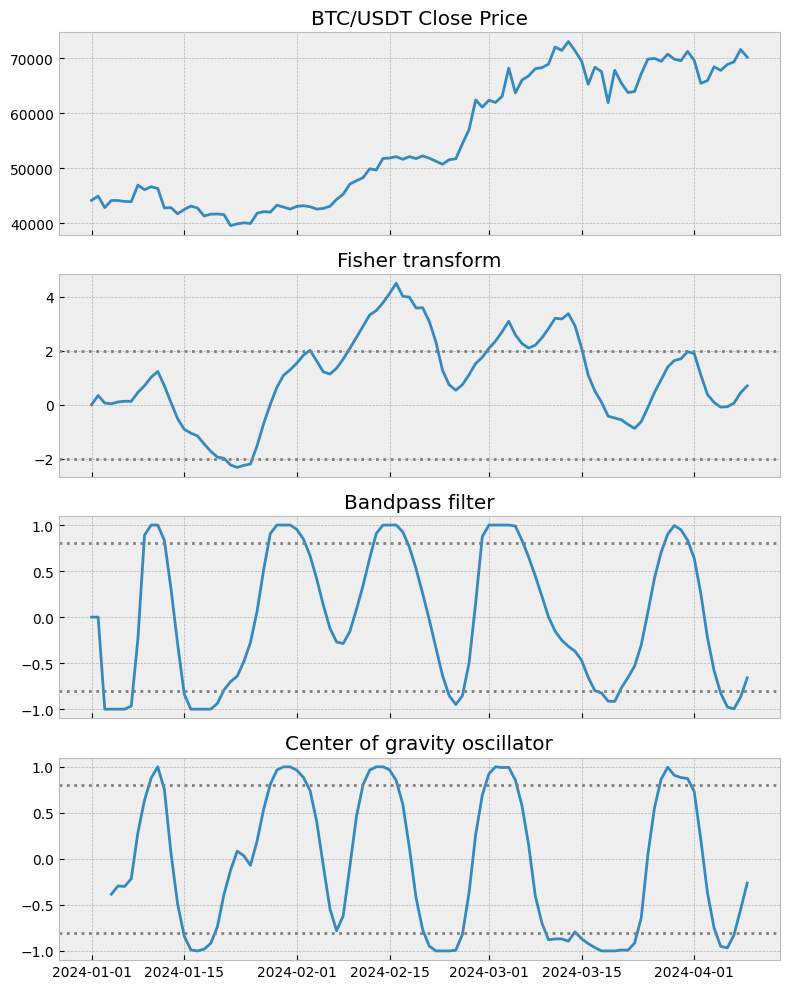

In [9]:
# 设置参数
ticker = "BTC/USDT"
start_date = dt.datetime(2024, 1, 1)
end_date = dt.datetime(2024, 4, 30)

fisher_period = 10  # 菲舍尔转换的回溯期
bp_period = 20  # 带通滤波器的回溯期
bp_width = 0.3  # 带通滤波器的带宽
cgosc_period = 10  # 超级震荡指标的回溯期

# 选择数据
ohlcv_ticker = ohlcv.query("symbol == @ticker").loc[start_date:end_date].copy()

# 计算指标
ohlcv_ticker["ft"] = fisher_transform(ohlcv_ticker["close"], period=fisher_period)
ohlcv_ticker["bp"] = bandpass(
    ohlcv_ticker["close"], period=bp_period, bandwidth=bp_width
)
ohlcv_ticker["cgosc"] = stoch_center_gravity_osc(
    ohlcv_ticker["close"], period=cgosc_period
)

# 创建图表
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 10), sharex=True
)

ax0.plot(ohlcv_ticker["close"])
ax0.set_title(f"{ticker} Close Price")

ax1.plot(ohlcv_ticker["ft"])
ax1.set_title("Fisher transform")
ax1.axhline(2, color="grey", linestyle="dotted")
ax1.axhline(-2, color="grey", linestyle="dotted")

ax2.plot(ohlcv_ticker["bp"])
ax2.set_title("Bandpass filter")
ax2.axhline(0.8, color="grey", linestyle="dotted")
ax2.axhline(-0.8, color="grey", linestyle="dotted")

ax3.plot(ohlcv_ticker["cgosc"])
ax3.set_title("Center of gravity oscillator")
ax3.axhline(0.8, color="grey", linestyle="dotted")
ax3.axhline(-0.8, color="grey", linestyle="dotted")

plt.tight_layout()